In [2]:
import math
import numpy as np
from sympy import Symbol
import matplotlib.pyplot as plt
#GIVENS: (EVERYTHING IN S.I.)
#ASSUME FILLED CIRCULAR ROD, MASS OF BLOCK, TYPE OF ROD MATERIAL
'''
-F: Force acting on beam -> (mass of load)                                       kg 
-L: Length of the beam between the supports                                      m
-E: Modulus of elasticity -                                                      Pa
-I: Area moment of Inertia of cross-section - (need dimensions of rod)           kg*m^2
-r: Radius of rod                                                                m
'''
#creating lists to graph the values later
deflectionList = []
energyList = []

#===========================================================================================================
#returns coefficients for natural cubic spline through a list of points (x coords. and y coords.)
def natural3Spline(xlist, ylist):
    n = len(xlist)-1
    hlist = np.zeros(n+1)
    alphaList = np.zeros(n+1)
    Llist = np.zeros(n+1)
    mulist = np.zeros(n+1)
    zlist = np.zeros(n+1)
    clist = np.zeros(n+1)
    blist = np.zeros(n+1)
    dlist = np.zeros(n+1)
    
    #STEP 1
    for i in range(n):
        hlist[i] = xlist[i+1] - xlist[i]
    #STEP 2
    for i in range(1,n):
        alphaList[i] = (3/hlist[i])*(ylist[i+1]-ylist[i]) - (3/hlist[i-1])*(ylist[i] - ylist[i-1])
    #STEP 3
    Llist[0] = 1
    zlist[0] = 0
    clist[0] = 0
    #STEP 4
    for i in range(1,n):
        Llist[i] = 2*(xlist[i+1] - xlist[i-1]) - hlist[i-1]*mulist[i-1]
        mulist[i] = hlist[i]/Llist[i]
        zlist[i] = (alphaList[i] - hlist[i-1]*zlist[i-1])/(Llist[i])
        
    Llist[n] = 1
    zlist[n] = 0
    clist[n] = 0
    
    for j in range(n-1,-1,-1):
        clist[j] = zlist[j] - mulist[j]*clist[j+1]
        blist[j] = (ylist[j+1]-ylist[j])/hlist[j] - hlist[j]*(clist[j+1] + 2*clist[j])/3
        dlist[j] = (clist[j+1] - clist[j])/(3*hlist[j])
    
    finallist = []
    finallist.append(ylist[0:n])
    finallist.append(blist[0:n])
    finallist.append(clist[0:n])
    finallist.append(dlist[0:n])
    
    #print(n)
    return finallist      
#=========================================================================================================

#1st Param: The coefficents from the spline function
#2nd Param: The x values of points given in problem

#Takes the coefficents from the spline and turns it into interpolating polynomial via 'symbols'
def cubicPoly(result, xlist):
    #symbol x to not evaluate 
    x = Symbol('x')
    n = len(result[0])
    
    #print('There are', n, 'polynomial(s)')
    #Seperates the coefficients into seperate lists
    a = result[0]
    b = result[1]
    c = result[2]
    d = result[3]
    #Calculates 2 polynomials(usually 2 for our problem)
    j = 0
    
    if (n == 2):
        s1 = a[j] + (b[j]*(x-xlist[j])) + (c[j]*(x-xlist[j])**2) + (d[j]*(x - xlist[j])**3)
        s2 = a[j+1] + (b[j+1]*(x-xlist[j+1])) + (c[j+1]*(x-xlist[j+1])**2) + (d[j+1]*(x - xlist[j+1])**3)
        return s1,s2
    elif(n == 1):
        s1 = a[j] + (b[j]*(x-xlist[j])) + (c[j]*(x-xlist[j])**2) + (d[j]*(x - xlist[j])**3)
        #print("Only 1 polynomial!")
        return s1
    else:
        print("Not correct number of points. This function returns 1 or 2 polys. Not any other number")
        return
#=========================================================================================================

def der(f,pt,dx):
    #takes in a functin whose variable is already declared a 'Symbol'
    #f(x+dx)-f(x-dx)/2*dx is the plan
    fp = f.subs({x:(pt+dx)}) #calculates f(x+dx)
    fm = f.subs({x:(pt-dx)}) #calculates f(x-dx) 
    out = (fp-fm)/(2*dx)  #plugs them into our derivative formula
    return out

def der2(f,pt,dx):
    #does the same this as above, but the with f'(x+dx) anf f'(x-dx)
    fp = der(f,pt+dx,dx)
    fm = der(f,pt-dx,dx)
    out = (fp-fm)/(2*dx)
    return out
#=========================================================================================================

#input 2 polynomials seperately with corresponding bounds and funct#
#will return value of integral of 2nd derivative of polynomial using 2-point Gauss quadrature

def quadraGauss(xlist, res):
    n= len(xlist) - 1

    a = xlist[0]
    b = xlist[n]
    c1 = (b-a)/2
    c2 = (b-a)/2
    
    x1 = ((b-a)/2) * (-1/math.sqrt(3)) + ((b+a)/2) 
    x2 = ((b-a)/2) * (1/math.sqrt(3)) + ((b+a)/2) 
    
    fx1 = (der2(res,x1, 0.0001))**2
    fx2 = (der2(res,x2, 0.0001))**2
    
    areaApp = (c1*fx1) + (c2*fx2)
    return areaApp
#==========================================================================================================

def energy(E, radiusRod, w, d, integral):
    
    I = (math.pi/4)* radiusRod**4
    return (1/2)*(E*I) * integral - (w*d)
#==========================================================================================================

def allTogetherNow(beamLength, massPosition, loadMass, deflection):
    
    #these constants are physical properties of the beam that can be changed if the beam changes material or shape 
    E = 69000000000
    rodRad = 0.01
    w = loadMass * 9.8
    
    xList = [0, massPosition, beamLength]
    yList = [0, deflection, 0]
    
    naturalCoeff = natural3Spline(xList, yList)
    ourPoly = cubicPoly(naturalCoeff, xList)
    
    #print('P0(x) =',ourPoly[0], 'on', xList[0:2])
    #print('P1(x) =',ourPoly[1], 'on', xList[1:3])
    
    area1 = quadraGauss(xList[0:2], ourPoly[0])
    area2 = quadraGauss(xList[1:3], ourPoly[1])

    intTerm = area1 + area2
    #print('Total Area =',intTerm)
    
    dEnergy = energy(E, rodRad, w, deflection, intTerm)
    return(dEnergy)
#==========================================================================================================

def mini(beamLength, massPosition, loadMass):
    x=Symbol('x')
    i=0
    pt=[]
    coords1= []
    coords2=[]
    while i <=0.1:
        y = allTogetherNow(beamLength,massPosition,loadMass,i)
        coords1.append([i,y])
        #fills a list with coordinates, (deflection, energy)
        
        i=i+0.0001
    for k in range(len(coords1)):
        if (coords1[k][1]-coords1[k-1][1]) >= 0 and k!=0:
            print(coords1[k-1])
            pt.append(coords1[k-1])
            break
            #check to see when an energy value is larger than the energy value before it in the list
    #print(pt)
    i=pt[0][0]-0.0001
    while i <= (pt[0][0]+0.00005):
        y=allTogetherNow(beamLength,massPosition,loadMass,i)
        coords2.append([i,y])
        #print(y)
        i=i+0.000001
        #fills another list with coordinates (deflection, energy) but deflection increases by 0.000001 this time
    top=0
    m=0
    for k in range(len(coords2)):
        if coords2[k][1]<top:
            top= coords2[k][1]
            m=k
            #checks to see when energy value is larger than the energy value before it in the list
    print('coord =',coords2[m])
    topc=[coords2[m][0],top]
    print('Success! The coordinates of the estimated minimum are:',topc)
    return topc, massPosition
#==========================================================================================================

#We check what the value of the result actually is and can compare our answer to the real answer
def deflection(x, a, L, m, rad):
    ###FUNCTION INPUT
    #x: a point between 0 and L
    #a: the position of the load
    #L: the length of the beam
    #m: the mass of the load
    
    ###FUNCTION OUTPUT
    #y: the deflection at x
    
    #W: the weight of the load
    #E: molulus of elasticity
    #I: moment of inertia
    E =  69000000000
    I = (math.pi/4)* rad**4
    W = m*9.81
    b = L - a
    v = L - x
    if (x<0 or x>L):
        print('ERROR: x is out of bound.')
        return
    elif(x<a):
        y = -(W*b*x)*(L**2-x**2-b**2)/(6*E*I*L)
    elif(x>=a):
        y = -(W*a*v)*(L**2-v**2-a**2)/(6*E*I*L)
        
    return y
#==========================================================================================================

In [3]:
#We calculate our results here by calling the minimization function
x= Symbol('x')
z = mini(1,0.35,100)
d = 0

#while loop that runs through multiple deflection cases and calculates energy for each one
while(d <= 0.05):
    integral = allTogetherNow(1,0.35, 100, d)
    energyList.append(integral)
    deflectionList.append(d)
    d = d + 0.0001

[0.031199999999999867, -15.2870867341683]
coord = [0.031197999999999965, -15.2870867929009]
Success! The coordinates of the estimated minimum are: [0.031197999999999965, -15.2870867929009]


So we calculated the minimum to be ([0.031197999999999965, -15.2870867929009], 0.35)


<function matplotlib.pyplot.show(*args, **kw)>

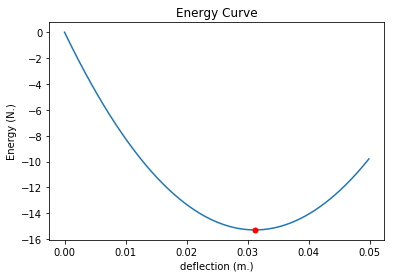

In [5]:
#plotting
plt.figure(1)
plt.plot(deflectionList,energyList)

plt.title('Energy Curve')
plt.xlabel('deflection (m.)')
plt.ylabel('Energy (N.)')


print("So we calculated the minimum to be", z)
plt.plot([z[0][0]], [z[0][1]], marker='o', markersize=5, color="red")
plt.show

P0(x) = -0.195905808477237*x**3 + 0.113135604395604*x on [0, 0.35]
P1(x) = 0.0411402197802197*x + 0.105487743026204*(x - 0.35)**3 - 0.205701098901099*(x - 0.35)**2 + 0.0167989230769231 on [0.35, 1]


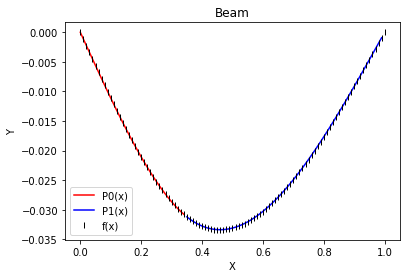

In [6]:
xListCheck = [0, z[1], 1]
yListCheck = [0, z[0][0], 0]

coeffs = natural3Spline(xListCheck, yListCheck)
finPoly = cubicPoly(coeffs, xListCheck)

print('P0(x) =',finPoly[0], 'on', xListCheck[0:2])
print('P1(x) =',finPoly[1], 'on', xListCheck[1:3])

x = Symbol('x')

x1List = []
y1List = []

d = xListCheck[0]
while(d <= xListCheck[1]):
    expr1 = finPoly[0]
    x1List.append(d)
    y1List.append(expr1.subs(x,d))
    d = d + 0.01
    
x2List = []
y2List = []

e = xListCheck[1]
while(e <= xListCheck[2]):
    expr2 = finPoly[1]
    x2List.append(e)
    y2List.append(expr2.subs(x,e))
    e = e + 0.01

y1List = [-1*x for x in y1List]
y2List = [-1*x for x in y2List]
    
plt.figure(2)
plt.plot(x1List,y1List,'r')
plt.plot(x2List,y2List, 'b')
plt.title('Beam')
plt.xlabel('X')
plt.ylabel('Y')



xfList = [x for x in np.arange(0.0,1.01, 0.01)]
yfList = [deflection(x,0.35,1.0,100,0.01) for x in xfList]
plt.figure(2)
plt.plot(xfList,yfList, 'k|')


plt.gca().legend(('P0(x)','P1(x)','f(x)'))
plt.show()



In [11]:
check = deflection(0.35,0.35, 1, 100, 0.01)
print("The analytically derived value of deflection for this beam problem is:" ,-check, '\n')
print('The deflection from our calculations: ', z[0][0])


The analytically derived value of deflection for this beam problem is: 0.03122997111480312 

The deflection from our calculations:  0.031197999999999965
